In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from dateutil import parser

url = "https://docs.google.com/spreadsheets/d/1kr8GPDk2mnHoowmvBgeBkQrgGP6jtU8N6od1MM8Nx2g/export?format=csv&gid=595253734"
df = pd.read_csv(url)

def parse_mixed_date(date_str):
    try:
        return parser.parse(date_str, dayfirst=True)
    except Exception:
        return pd.NaT

# df = df.iloc[:-8]
df['Scan date'] = df['Scan date'].astype(str).apply(parse_mixed_date)
df['Commit frequency'] = df['Commit frequency'].str.capitalize()
# df['Scan date'] = pd.to_datetime(df['Scan date'], errors='coerce', dayfirst=False)
label_map = {
    'Very low': 0,
    'Low': 1,
    'Medium': 2,
    'High': 3,
    'Very high': 4
}
df['Evaluate'] = df["Evaluate"].map(label_map)


df_copy = df.loc[:, (df != 0).any(axis=0)]
df_copy = df_copy.drop(labels=['Sprint'], axis=1)

In [2]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 783 entries, 0 to 782
Data columns (total 15 columns):
 #   Column                                                 Non-Null Count  Dtype         
---  ------                                                 --------------  -----         
 0   Change code line number                                783 non-null    int64         
 1   Total code line                                        783 non-null    int64         
 2   Number of vulnerable modules                           783 non-null    int64         
 3   Total modules                                          783 non-null    int64         
 4   Number of people involved in development               783 non-null    int64         
 5   Time to complete each version                          783 non-null    object        
 6   Commit frequency                                       783 non-null    object        
 7   Type of environment                                    783 non-null    

In [3]:
df_copy

,Change code line number,Total code line,Number of vulnerable modules,Total modules,Number of people involved in development,Time to complete each version,Commit frequency,Type of environment,Number of libraries detected errors,Scan date,Number of potential weaknesses,Severity of the threat,Number of environmental configuration vulnerabilities,Evaluate,Repo
0,279,53409,1,1,3,7 days,Weekly,VPS,21,2024-05-16,23,5,2,4,6am_BE
1,393,53802,1,1,3,7 days,Weekly,VPS,21,2024-05-17,23,5,2,4,6am_BE
2,36,53838,1,1,3,7 days,Weekly,VPS,21,2024-05-17,23,5,2,4,6am_BE
3,250,54088,1,1,3,7 days,Weekly,VPS,21,2024-05-17,23,5,2,4,6am_BE
4,15,54103,1,1,3,7 days,Weekly,VPS,21,2024-05-18,23,5,2,4,6am_BE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
778,139,856,1,1,4,7 days,Weekly,VPS,3,2024-08-25,3,1,0,0,web-hly
779,214,1070,1,1,4,7 days,Weekly,VPS,3,2024-08-31,3,1,0,0,web-hly
780,255,1325,1,1,4,7 days,Weekly,VPS,5,2024-08-09,5,1,0,0,web-hly
781,329,1654,1,1,4,7 days,Weekly,VPS,5,2024-09-28,5,1,0,0,web-hly


In [4]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

def preprocess_timeseries_dataframe(df: pd.DataFrame):
    df = df.copy()
    df = df.loc[:, (df != 0).any(axis=0)]
    df = df.drop(labels=['Sprint'], axis=1)
    df['Scan date'] = pd.to_datetime(df['Scan date'])

    categorical_columns = ['Time to complete each version', 'Commit frequency', 'Type of environment', 'Repo']
    group_sum_col = 'Change code line number'
    target_col = 'Evaluate'
    date_col = 'Scan date'

    all_dfs = []
    for repo, group in df.groupby('Repo'):
        # group by date to avoid duplicates before reindexing
        group = group.groupby(date_col).agg({
            group_sum_col: 'sum',
            'Number of vulnerable modules': 'mean',
            'Number of people involved in development': 'mean',
            'Number of libraries detected errors': 'mean',
            'Number of potential weaknesses': 'mean',
            'Severity of the threat': 'mean',
            'Number of environmental configuration vulnerabilities': 'mean',
            'Total code line': 'mean',
            'Total modules': 'mean',
            target_col: 'first',
            **{col: 'first' for col in categorical_columns}
        }).sort_index()

        # create full date index and reindex
        all_dates = pd.date_range(start=group.index.min(), end=group.index.max(), freq='D')
        group = group.reindex(all_dates, method='ffill')
        group[date_col] = group.index
        group['Repo'] = repo

        # identify filled-in rows and set code line to 0
        original_dates = df[df['Repo'] == repo]['Scan date'].unique()
        group[group_sum_col] = group[group_sum_col].where(group.index.isin(original_dates), 0)

        all_dfs.append(group)

    df_filled = pd.concat(all_dfs).reset_index(drop=True)

    # encode categoricals
    label_encoders = {}
    for col in categorical_columns:
        le = LabelEncoder()
        df_filled[col] = le.fit_transform(df_filled[col])
        label_encoders[col] = le

    # normalize features (excluding Scan date, Repo, Evaluate)
    feature_cols = df_filled.columns.difference([date_col, 'Repo', target_col])
    scaler = StandardScaler()
    df_filled[feature_cols] = scaler.fit_transform(df_filled[feature_cols])

    # final outputs
    X = df_filled.drop(columns=[date_col, 'Repo', target_col])
    y = df_filled[target_col]
    meta = df_filled[[date_col, 'Repo']]

    return X, y, meta, label_encoders, scaler

In [5]:
X, y, meta, encoders, scaler = preprocess_timeseries_dataframe(df)
X

,Change code line number,Number of vulnerable modules,Number of people involved in development,Number of libraries detected errors,Number of potential weaknesses,Severity of the threat,Number of environmental configuration vulnerabilities,Total code line,Total modules,Time to complete each version,Commit frequency,Type of environment
0,0.175108,-0.298019,0.474702,0.884266,0.798831,1.371311,-0.083456,0.592564,-0.322577,0.30798,0.318056,0.642962
1,-0.163467,-0.298019,0.474702,0.884266,0.798831,1.371311,-0.083456,0.592564,-0.322577,0.30798,0.318056,0.642962
2,-0.163467,-0.298019,0.474702,0.884266,0.798831,1.371311,-0.083456,0.592564,-0.322577,0.30798,0.318056,0.642962
3,-0.163467,-0.298019,0.474702,0.884266,0.798831,1.371311,-0.083456,0.592564,-0.322577,0.30798,0.318056,0.642962
4,-0.163467,-0.298019,0.474702,0.884266,0.798831,1.371311,-0.083456,0.592564,-0.322577,0.30798,0.318056,0.642962
...,...,...,...,...,...,...,...,...,...,...,...,...
7568,-0.163467,-0.298019,1.069168,-0.820275,-0.907584,-1.140769,-1.022548,-0.551880,-0.322577,0.30798,0.318056,0.642962
7569,-0.163467,-0.298019,1.069168,-0.820275,-0.907584,-1.140769,-1.022548,-0.551880,-0.322577,0.30798,0.318056,0.642962
7570,-0.163467,-0.298019,1.069168,-0.820275,-0.907584,-1.140769,-1.022548,-0.551880,-0.322577,0.30798,0.318056,0.642962
7571,-0.163467,-0.298019,1.069168,-0.820275,-0.907584,-1.140769,-1.022548,-0.551880,-0.322577,0.30798,0.318056,0.642962


In [6]:
y

,Evaluate
0,4
1,4
2,4
3,4
4,4
...,...
7568,0
7569,0
7570,0
7571,0


In [7]:
meta

,Scan date,Repo
0,2024-04-06,0
1,2024-04-07,0
2,2024-04-08,0
3,2024-04-09,0
4,2024-04-10,0
...,...,...
7568,2024-11-04,19
7569,2024-11-05,19
7570,2024-11-06,19
7571,2024-11-07,19


In [8]:
ori_X = scaler.inverse_transform(X[list(scaler.feature_names_in_)]).astype(int)
ori_X = pd.DataFrame(data=ori_X, columns=list(scaler.feature_names_in_))

In [9]:
for col in ('Time to complete each version', 'Commit frequency', 'Type of environment'):
    ori_X[col] = encoders[col].inverse_transform(ori_X[col])

In [15]:
ori_X

,Change code line number,Commit frequency,Number of environmental configuration vulnerabilities,Number of libraries detected errors,Number of people involved in development,Number of potential weaknesses,Number of vulnerable modules,Severity of the threat,Time to complete each version,Total code line,Total modules,Type of environment
0,149,Weekly,2,27,3,29,1,5,7 days,55260,1,VPS
1,0,Weekly,2,27,3,29,1,5,7 days,55260,1,VPS
2,0,Weekly,2,27,3,29,1,5,7 days,55260,1,VPS
3,0,Weekly,2,27,3,29,1,5,7 days,55260,1,VPS
4,0,Weekly,2,27,3,29,1,5,7 days,55260,1,VPS
...,...,...,...,...,...,...,...,...,...,...,...,...
7568,0,Weekly,0,5,4,5,1,1,7 days,1653,1,VPS
7569,0,Weekly,0,5,4,5,1,1,7 days,1653,1,VPS
7570,0,Weekly,0,5,4,5,1,1,7 days,1653,1,VPS
7571,0,Weekly,0,5,4,5,1,1,7 days,1653,1,VPS


In [16]:
ori_meta  = meta.copy()
ori_meta['Repo'] = encoders['Repo'].inverse_transform(ori_meta['Repo'])
ori_meta

,Scan date,Repo
0,2024-04-06,6am_BE
1,2024-04-07,6am_BE
2,2024-04-08,6am_BE
3,2024-04-09,6am_BE
4,2024-04-10,6am_BE
...,...,...
7568,2024-11-04,web-hly
7569,2024-11-05,web-hly
7570,2024-11-06,web-hly
7571,2024-11-07,web-hly


In [17]:
ori_y = pd.DataFrame(data=y, columns=['Evaluate'])
ori_y

,Evaluate
0,4
1,4
2,4
3,4
4,4
...,...
7568,0
7569,0
7570,0
7571,0


In [18]:
import os
col_names = list(ori_X.columns) + list(ori_meta.columns) + list(ori_y.columns)
ori_data = pd.concat([ori_X, ori_meta, ori_y], ignore_index=True, axis=1)
ori_data.columns = col_names
ori_data = ori_data[df_copy.columns.tolist()]
os.makedirs('resources', exist_ok=True)

# Lưu file vào thư mục resources
ori_data.to_csv('resources/data_cleaned_v3.csv', index=False)

### Model

In [19]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions import Normal

class BayesianDense(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.w_mu = nn.Parameter(torch.Tensor(out_features, in_features))
        self.w_sigma = nn.Parameter(torch.Tensor(out_features, in_features))
        self.b_mu = nn.Parameter(torch.Tensor(out_features))
        self.b_sigma = nn.Parameter(torch.Tensor(out_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_normal_(self.w_mu, mode='fan_in')
        nn.init.constant_(self.w_sigma, -3)
        nn.init.constant_(self.b_mu, 0.1)
        nn.init.constant_(self.b_sigma, -3)

    def forward(self, x):
        w = Normal(self.w_mu, torch.exp(self.w_sigma)).rsample()
        b = Normal(self.b_mu, torch.exp(self.b_sigma)).rsample()
        return F.linear(x, w, b)

class MyModel(nn.Module):
    def __init__(self, input_features=12, timesteps=5, num_classes=5):
        super().__init__()
        assert input_features == 12, 'only 10 features supported right now'

        self.input_dense = BayesianDense(input_features, 32)
        self.lstm = nn.LSTM(32, 64, num_layers=2, batch_first=True)

        self.bayesian_layers = nn.ModuleList([
            BayesianDense(64, 64),
            BayesianDense(64, 48),
            BayesianDense(48, 48),
            BayesianDense(48, 32)
        ])

        self.dropout = nn.Dropout(0.1)
        self.final_dense = BayesianDense(32, num_classes)

        self.swish = lambda x: x * torch.sigmoid(x)

    def forward(self, x):
        batch_size, T, _ = x.shape

        x = self.swish(self.input_dense(x))  # (batch, T, 32)
        lstm_out, _ = self.lstm(x)  # (batch, T, 64)

        x = lstm_out
        for layer in self.bayesian_layers:
            x = self.swish(layer(x))

        x = self.dropout(x)
        logits = self.final_dense(x)  # (batch, T, num_classes)
        return logits

def evaluate(model, loader, verbose=True):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for x_batch, y_batch in loader:
            output = model(x_batch)  # (batch, T, num_classes)
            preds = output.argmax(dim=-1)
            all_preds.append(preds.flatten())
            all_labels.append(y_batch.flatten())
    all_preds = torch.cat(all_preds)
    all_labels = torch.cat(all_labels)
    acc = (all_preds == all_labels).float().mean().item()
    if verbose:
        print(f"accuracy: {acc:.4f}")
    return acc

def train(model, loader, optimizer, criterion, val_loader=None, epochs=100):
    model.train()
    train_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        total_loss = 0
        for x_batch, y_batch in loader:
            optimizer.zero_grad()
            output = model(x_batch)  # shape: (batch, T, num_classes)
            loss = criterion(output.view(-1, output.shape[-1]), y_batch.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        avg_loss = total_loss / len(loader)
        train_losses.append(avg_loss)

        # Validation accuracy
        if val_loader:
            acc = evaluate(model, val_loader, verbose=False)
            val_accuracies.append(acc)

        print(f"epoch {epoch+1}: loss = {avg_loss:.4f}" + (f", val. acc. = {acc:.4f}" if val_loader else ""))

    return train_losses, val_accuracies

In [20]:
from torch.utils.data import Dataset, DataLoader, random_split

# class RepoDataset(Dataset):
#     def __init__(self, X_df, y_series, meta_df, timesteps=5):
#         self.samples = []
#         self.meta = []

#         grouped = meta_df.groupby("Repo")
#         for repo_id, group_indices in grouped.groups.items():
#             group = meta_df.loc[group_indices].sort_values("Scan date")
#             sorted_idx = group.index.tolist()
#             if len(sorted_idx) < timesteps:
#                 continue
#             for i in range(len(sorted_idx) - timesteps + 1):
#                 window_idx = sorted_idx[i:i + timesteps]
#                 x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
#                 y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
#                 # meta_seq = meta_df.loc[window_idx].iloc[-1]
#                 self.samples.append((x_seq, y_seq))

#     def __len__(self):
#         return len(self.samples)

#     def __getitem__(self, idx):
#         return self.samples[idx]

# train_repos = [0, 1, 2]
# test_repos = [3]

# train_mask = meta['Repo'].isin(train_repos)
# test_mask = meta['Repo'].isin(test_repos)

# X_train = X[train_mask]
# y_train = y[train_mask]
# meta_train = meta[train_mask]

# X_test = X[test_mask]
# y_test = y[test_mask]
# meta_test = meta[test_mask]

# timesteps = 5
# train_dataset = RepoDataset(X_train, y_train, meta_train, timesteps=timesteps)
# test_dataset = RepoDataset(X_test, y_test, meta_test, timesteps=timesteps)

# batch_size = 32
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [21]:
# model = MyModel(input_features=10, timesteps=timesteps, num_classes=5)

# optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
# criterion = nn.CrossEntropyLoss()

# train_losses, val_accuracies = train(
#     model, train_loader, optimizer, criterion,
#     val_loader=test_loader, epochs=200
# )

# plt.figure(figsize=(12, 5))

# plt.subplot(1, 2, 1)
# plt.plot(train_losses)
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.title('Loss')
# plt.grid(True)

# plt.subplot(1, 2, 2)
# plt.plot(val_accuracies, color='green')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy')
# plt.title('Accuracy')
# plt.grid(True)

# plt.tight_layout()
# plt.show()

In [22]:
class RepoSplitTimeSeriesDataset(Dataset):
    def __init__(self, X_df, y_series, meta_df, timesteps=5, mode="train", split_ratio=0.8):
        self.samples = []
        assert mode in ["train", "val"], "mode must be 'train' or 'val'"

        grouped = meta_df.groupby("Repo")

        for repo_id, group_indices in grouped.groups.items():
            # sort by time within each repo
            group = meta_df.loc[group_indices].sort_values("Scan date")
            sorted_idx = group.index.tolist()

            total = len(sorted_idx)
            split_point = int(total * split_ratio)

            if total < timesteps:
                continue  # skip short repos

            if mode == "train":
                use_idx = sorted_idx[:split_point]
            else:  # val
                use_idx = sorted_idx[split_point:]

            # re-slide within the selected portion
            for i in range(len(use_idx) - timesteps + 1):
                window_idx = use_idx[i:i + timesteps]
                x_seq = torch.tensor(X_df.loc[window_idx].values, dtype=torch.float32)
                y_seq = torch.tensor(y_series.loc[window_idx].values, dtype=torch.long)
                meta_seq = meta_df.loc[window_idx].iloc[-1].to_dict()
                self.samples.append((x_seq, y_seq))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        return self.samples[idx]


timesteps = 5
train_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="train", split_ratio=0.1)
val_dataset = RepoSplitTimeSeriesDataset(X, y, meta, timesteps=timesteps, mode="val", split_ratio=0.1)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
model = MyModel(input_features=12, timesteps=timesteps, num_classes=5)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()

train_losses, val_accuracies = train(
    model, train_loader, optimizer, criterion,
    val_loader=val_loader, epochs=100
)

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.grid(True)

plt.tight_layout()
plt.show()

epoch 1: loss = 1.5820, val. acc. = 0.3264
epoch 2: loss = 1.5473, val. acc. = 0.3434
epoch 3: loss = 1.5046, val. acc. = 0.3639
epoch 4: loss = 1.4674, val. acc. = 0.3592
epoch 5: loss = 1.3935, val. acc. = 0.3845
epoch 6: loss = 1.2816, val. acc. = 0.4102
epoch 7: loss = 1.1059, val. acc. = 0.4528
epoch 8: loss = 0.9606, val. acc. = 0.5125
epoch 9: loss = 0.8767, val. acc. = 0.6299
epoch 10: loss = 0.7655, val. acc. = 0.6743
epoch 11: loss = 0.7191, val. acc. = 0.7183
epoch 12: loss = 0.6357, val. acc. = 0.7484
epoch 13: loss = 0.5930, val. acc. = 0.8367
epoch 14: loss = 0.5219, val. acc. = 0.8640
epoch 15: loss = 0.4168, val. acc. = 0.8847
epoch 16: loss = 0.3545, val. acc. = 0.9146
epoch 17: loss = 0.3251, val. acc. = 0.9144
epoch 18: loss = 0.2758, val. acc. = 0.9165
epoch 19: loss = 0.2445, val. acc. = 0.9284
epoch 20: loss = 0.2158, val. acc. = 0.9248
epoch 21: loss = 0.2017, val. acc. = 0.9215
epoch 22: loss = 0.1866, val. acc. = 0.9326
epoch 23: loss = 0.1811, val. acc. = 0.93

In [ ]:
print(y.value_counts(normalize=True))

Evaluate
1    0.284459
0    0.266693
4    0.237602
2    0.133151
3    0.078094
Name: proportion, dtype: float64


In [ ]:
import numpy as np

def predict_with_uncertainty(model, x, runs=50, device='cpu'):
    model.eval()
    preds = []

    with torch.no_grad():
        for _ in range(runs):
            output = model(x.to(device))  # shape: (1, T, num_classes)
            prob = F.softmax(output, dim=-1)  # shape: (1, T, num_classes)
            preds.append(prob.cpu().numpy())

    preds = np.stack(preds, axis=0)  # shape: (runs, 1, T, num_classes)
    mean_pred = preds.mean(axis=0)[0]   # shape: (T, num_classes)
    std_pred = preds.std(axis=0)[0]     # shape: (T, num_classes)

    return mean_pred, std_pred  # one per timestep

In [ ]:
def plot_prediction_with_uncertainty(mean_pred, std_pred, timestep=0, class_names=None):
    if class_names is None:
        class_names = [f'Class {i}' for i in range(mean_pred.shape[1])]

    probs = mean_pred[timestep]  # shape: (num_classes,)
    stds = std_pred[timestep]    # shape: (num_classes,)

    plt.figure(figsize=(5, 3))
    plt.bar(range(len(probs)), probs, yerr=stds, capsize=5, color='skyblue', alpha=0.8)
    plt.xticks(range(len(probs)), class_names)
    plt.ylabel("Predicted Probability")
    plt.title(f"Uncertainty at timestep {timestep}")
    plt.grid(axis='y')
    plt.show()

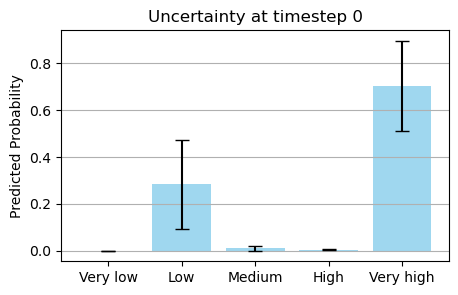

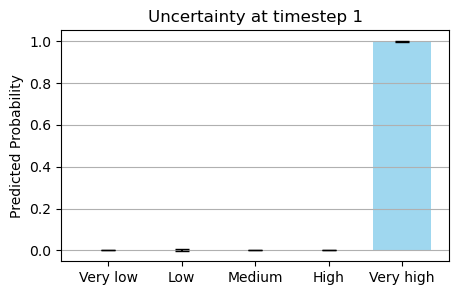

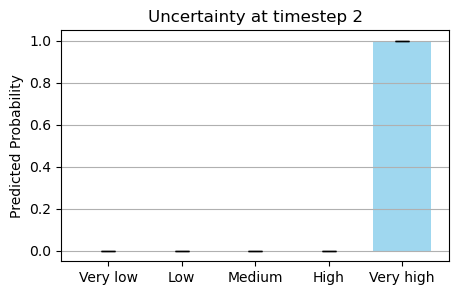

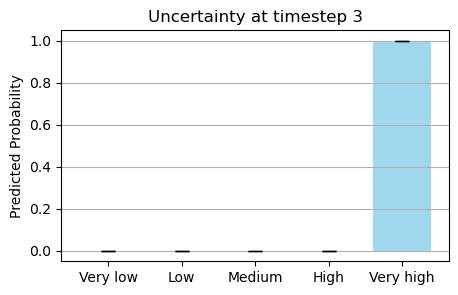

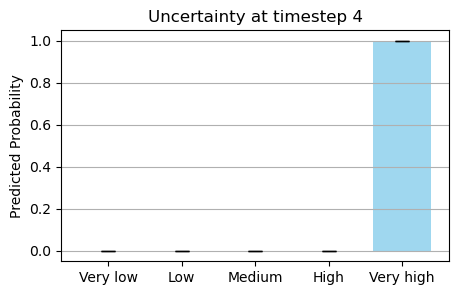

In [ ]:
x_sample = val_dataset[0][0].unsqueeze(0)  # shape: (1, T, F)
mean, std = predict_with_uncertainty(model, x_sample, runs=10, device='cpu')
for timestep in range(5):
    plot_prediction_with_uncertainty(mean, std, timestep=timestep, class_names=["Very low", "Low", "Medium", "High", "Very high"])
# x_sample.shape

In [ ]:
def bayesian_predictive_entropy(model, x, runs=10, device='cpu'):
    model.eval()
    predictions = []

    with torch.no_grad():
        for _ in range(runs):
            out = model(x.to(device))  # shape: (1, T, C)
            probs = F.softmax(out, dim=-1)  # shape: (1, T, C)
            predictions.append(probs.cpu().numpy())

    # shape: (runs, 1, T, C)
    preds = np.stack(predictions, axis=0)

    # average softmax predictions across runs
    mean_pred = preds.mean(axis=0)[0]  # shape: (T, C)

    # Entropy: H[p] = -sum p log p
    entropy = -np.sum(mean_pred * np.log(mean_pred + 1e-12), axis=-1)  # shape: (T,)

    return mean_pred, entropy

In [ ]:
def plot_entropy(entropy, title="Predictive uncertainty"):
    import matplotlib.pyplot as plt
    plt.figure(figsize=(6, 4))
    plt.plot(entropy, marker='o', color='purple')
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel("Entropy")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

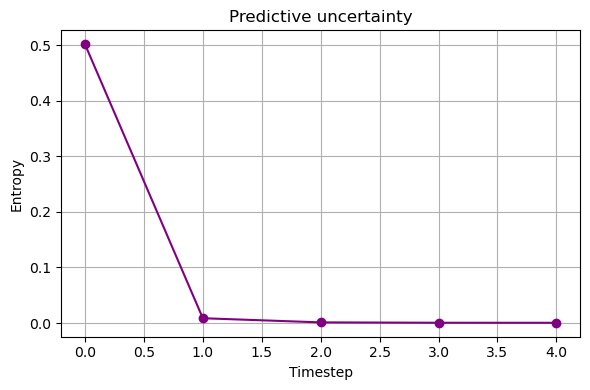

In [ ]:
mean, entropy = bayesian_predictive_entropy(model, x_sample, runs=10, device='cpu')
plot_entropy(entropy)